In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
## Load data

col = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path="boston_housing.npz", test_split=0.2, seed=113
)

x_train = pd.DataFrame(x_train,columns=col)
x_test = pd.DataFrame(x_test,columns=col)

Details about the features can be found here : http://lib.stat.cmu.edu/datasets/boston

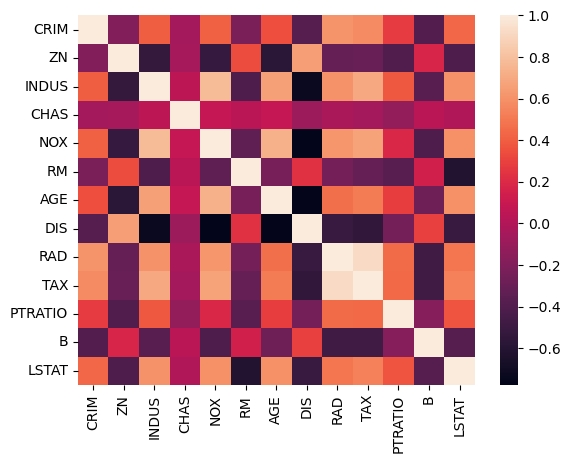

In [3]:
## EDA

sns.heatmap(x_train.corr())
plt.show()

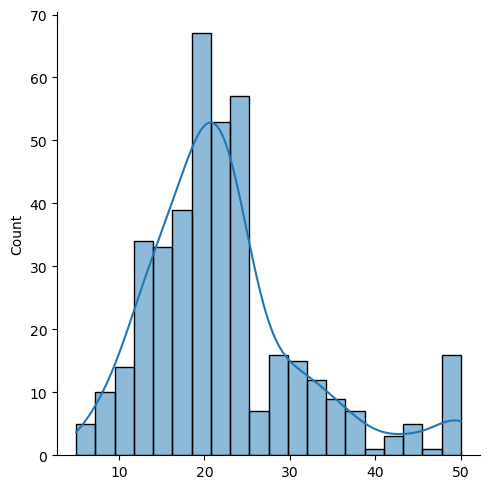

In [4]:
sns.displot(y_train,bins = 20, kde = True)
plt.show()

In [5]:
## Choose and evaluate model

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor()

cross_val_score(rf,x_train,y_train,cv = 5)

array([0.86058223, 0.88886352, 0.82633007, 0.71926599, 0.88970739])

## Interpretability

In [6]:
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)

Mean score of surrogate model : 0.890522622250691


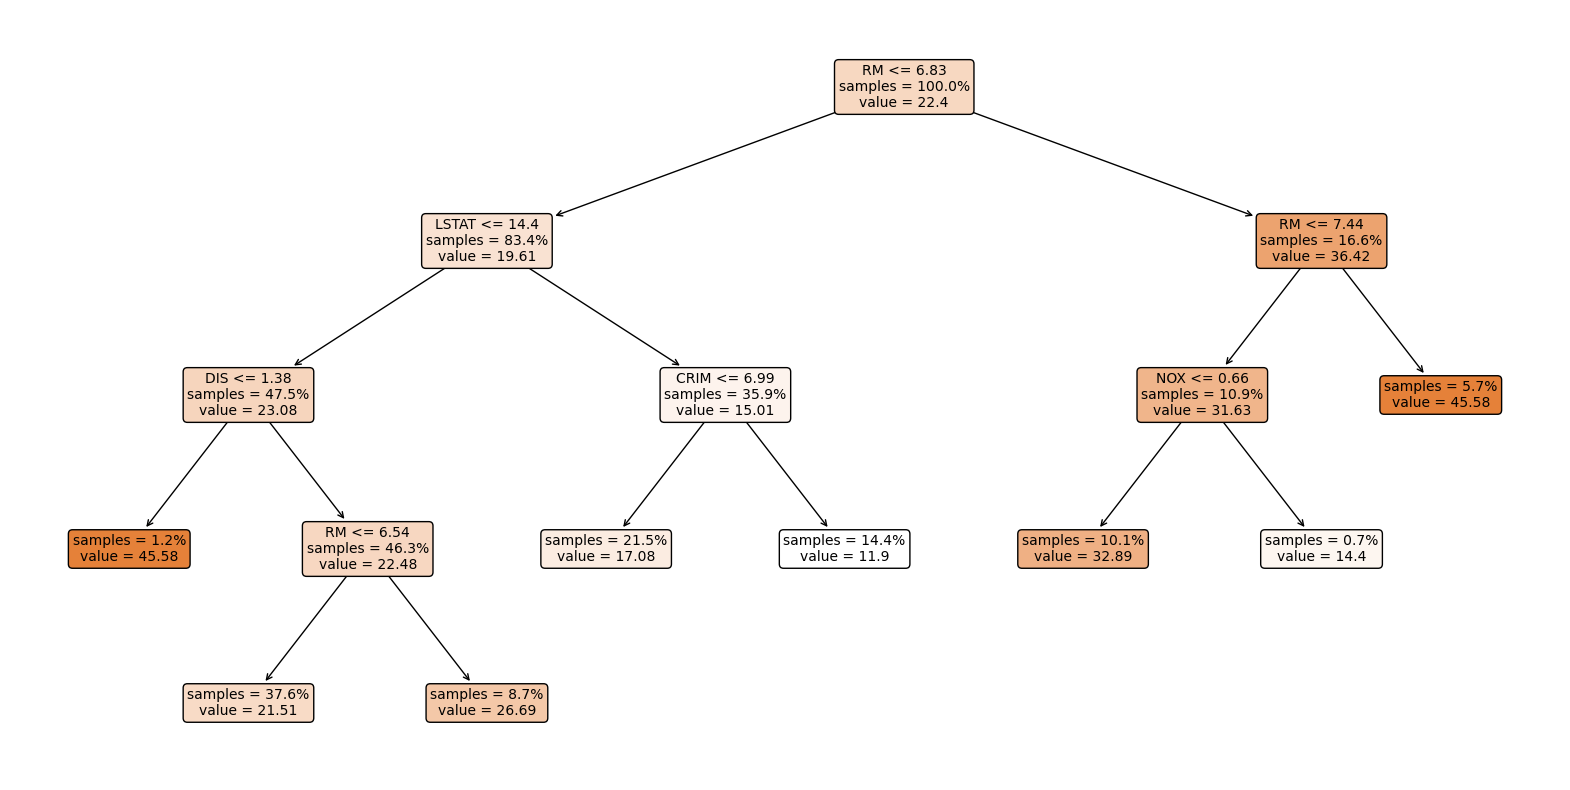

In [15]:
## Surogate model

from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.metrics import r2_score

tree = DecisionTreeRegressor(ccp_alpha=1)

print('Mean score of surrogate model : {}'.format(np.mean(cross_val_score(tree,x_test,y_pred))))

tree.fit(x_train, y_train)

f, ax = plt.subplots(figsize = (20,10))

plot_tree(tree,feature_names = col, precision = 2, rounded = True, fontsize = 10, ax = ax, filled = True, impurity = False, proportion = True, class_names = ['Default','Non-Default'], max_depth = 4)
plt.show()

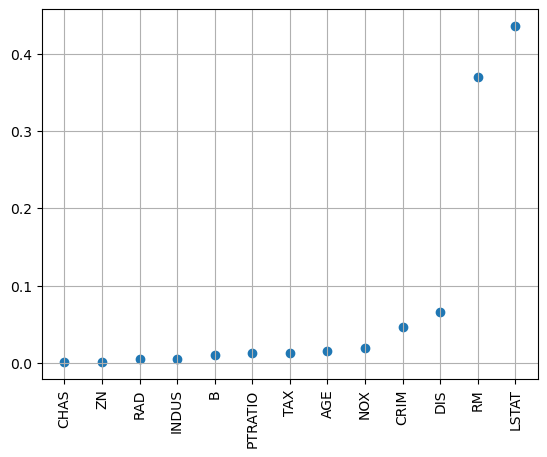

In [16]:
## Feature importance

feature_importances = rf.feature_importances_
index_sort = np.argsort(feature_importances)
plt.scatter(range(len(col)),feature_importances[index_sort])
plt.xticks(range(len(col)),np.array(col)[index_sort],rotation = 90)
plt.grid(True)
plt.show()

In [17]:
## PDP

from sklearn.inspection import partial_dependence

@interact

def pdp(feature = col):
    plt.figure()
    pdp = partial_dependence(rf, x_train, feature, kind = 'average')
    plt.title('Partial Dependence plot for ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Partial Dependence')
    plt.plot(pdp['values'][0],pdp['average'][0])
    plt.show()

interactive(children=(Dropdown(description='feature', options=('CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AG…

In [18]:
## ALE

from PyALE import ale

@interact
def ale_plot(feature = col):
    plt.figure()
    ale_eff = ale(X=x_train, model=rf, feature=[feature], grid_size=50, include_CI=True, predictors = col,feature_type = 'continuous')
    plt.title('ALE plot for ' + feature)
    plt.xlabel(feature)
    plt.ylabel('ALE')
    plt.show()
    


interactive(children=(Dropdown(description='feature', options=('CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AG…

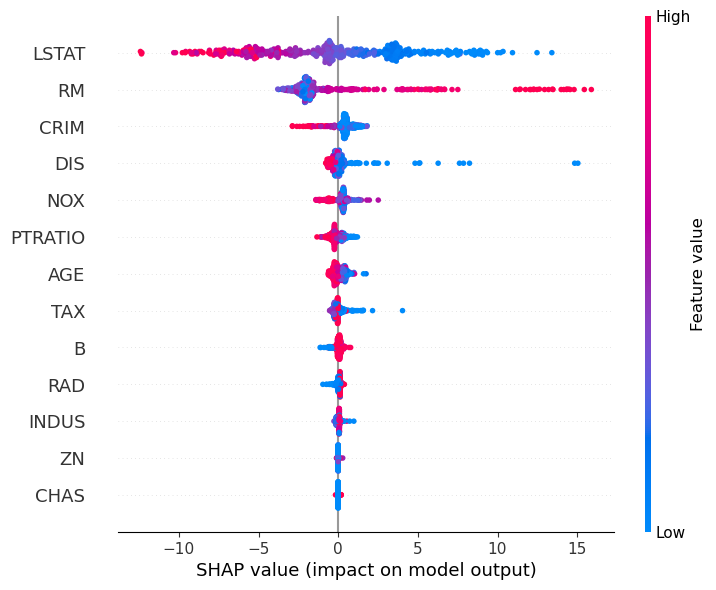

In [19]:
## SHAP

import shap

explainer_shap = shap.TreeExplainer(rf)
shap_values = explainer_shap.shap_values(x_train)
shap.summary_plot(shap_values, x_train,feature_names = col)

In [20]:
## Individual SHAP

@interact
def force_plot(index = (0,len(x_test)-1,1)):
    shap.initjs()
    return shap.force_plot(explainer_shap.expected_value, shap_values[index,:], x_test.iloc[index,:])

interactive(children=(IntSlider(value=50, description='index', max=101), Output()), _dom_classes=('widget-inte…